In [2]:
!pip install gym

In [4]:
import gym
print("Gym version:", gym.__version__)

Gym version: 0.26.2


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [6]:
%run assignment2_utils.py

Observation space:  Discrete(500)
Observation space size:  500
Reward Range:  (-inf, inf)
Number of actions:  6
Action description:  {0: 'Move south (down)', 1: 'Move north (up)', 2: 'Move east (right)', 3: 'Move west (left)', 4: 'Pickup passenger', 5: 'Drop off passenger'}


In [8]:
!pip install pygame

Observation space:  Discrete(500)
Observation space size:  500
Reward Range:  (-inf, inf)
Number of actions:  6
Action description:  {0: 'Move south (down)', 1: 'Move north (up)', 2: 'Move east (right)', 3: 'Move west (left)', 4: 'Pickup passenger', 5: 'Drop off passenger'}
[Episode   500] last500_avg_return=-184.48 last500_avg_steps=134.05
[Episode  1000] last500_avg_return=-40.97 last500_avg_steps= 45.79
[Episode  1500] last500_avg_return= -3.92 last500_avg_steps= 19.25
[Episode  2000] last500_avg_return=  1.10 last500_avg_steps= 15.81
[Episode  2500] last500_avg_return=  1.17 last500_avg_steps= 15.33
[Episode  3000] last500_avg_return=  1.32 last500_avg_steps= 15.08
[Episode  3500] last500_avg_return=  2.81 last500_avg_steps= 14.36
[Episode  4000] last500_avg_return=  2.70 last500_avg_steps= 14.79
[Episode  4500] last500_avg_return=  2.02 last500_avg_steps= 14.79
[Episode  5000] last500_avg_return=  3.26 last500_avg_steps= 14.49

=== Base Run (α=0.1, ϵ=0.1, γ=0.9) ===
Total Episodes

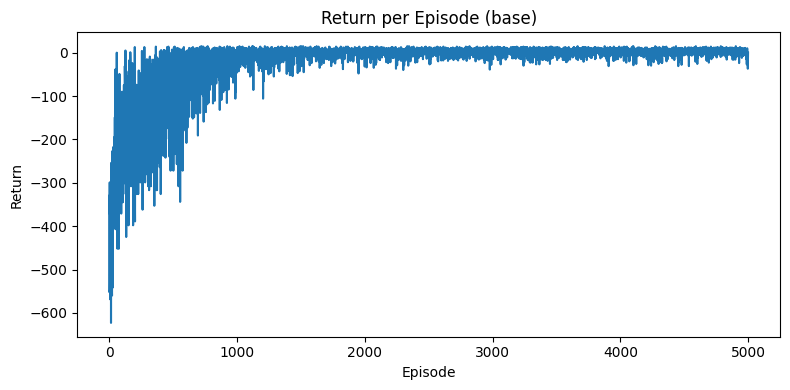

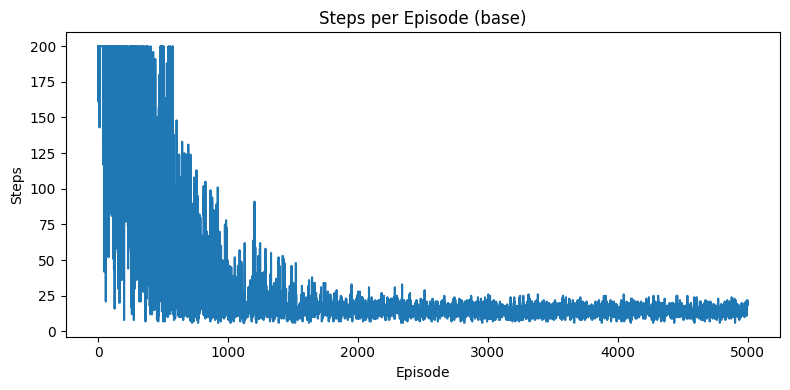

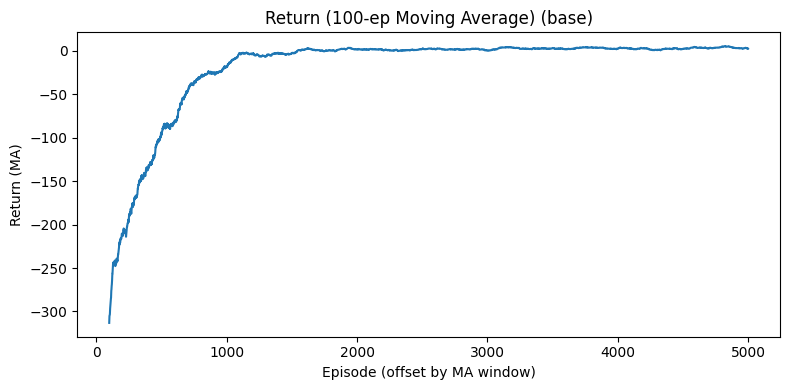

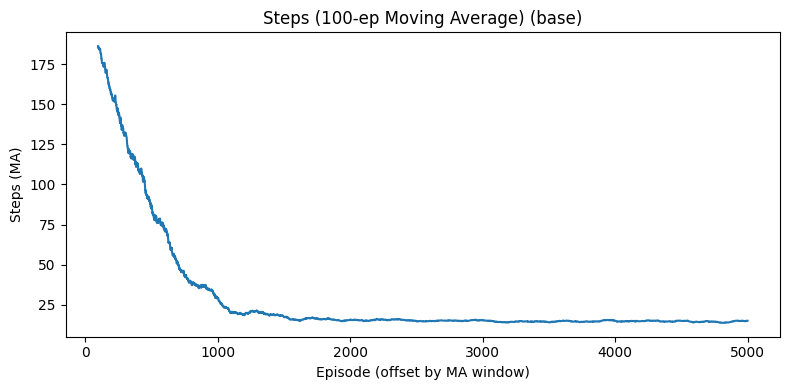

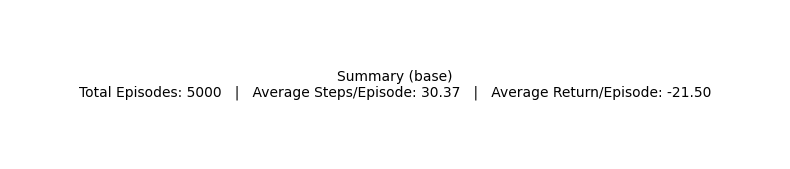


Playing trained policy visually (window/inline fallback):

State breakdown example (helper):
Passenger is at: Blue, wants to go to Green. Taxi currently at (5.0, 1.0)
[Episode   500] last500_avg_return=-275.40 last500_avg_steps=186.45
[Episode  1000] last500_avg_return=-241.88 last500_avg_steps=177.20
[Episode  1500] last500_avg_return=-217.55 last500_avg_steps=163.95
[Episode  2000] last500_avg_return=-189.90 last500_avg_steps=148.63
[Episode  2500] last500_avg_return=-169.75 last500_avg_steps=136.51
[Episode  3000] last500_avg_return=-139.86 last500_avg_steps=118.52
[Episode  3500] last500_avg_return=-121.61 last500_avg_steps=106.32
[Episode  4000] last500_avg_return=-102.89 last500_avg_steps= 92.82
[Episode  4500] last500_avg_return=-85.05 last500_avg_steps= 79.89
[Episode  5000] last500_avg_return=-68.16 last500_avg_steps= 68.24

=== LR Sweep: α=0.01 (ϵ=0.1, γ=0.9) ===
Total Episodes: 5000
Average Steps per Episode: 127.85
Average Return per Episode: -161.21
[Episode   500] last50

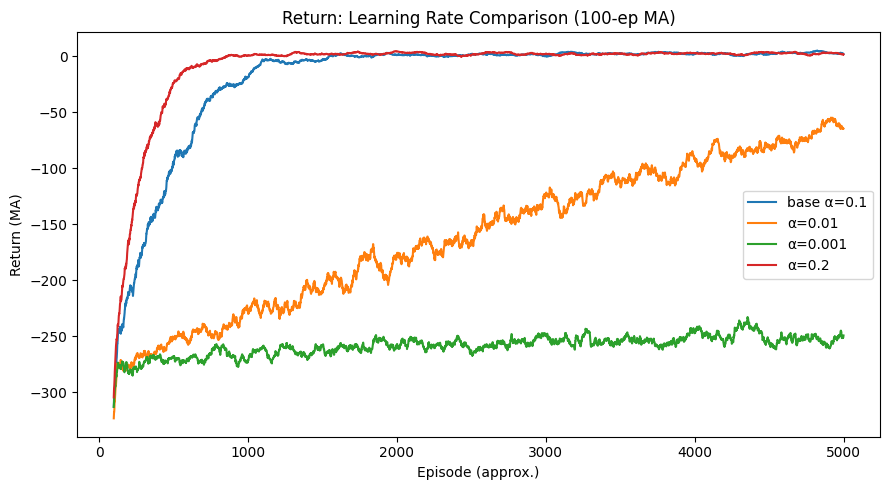

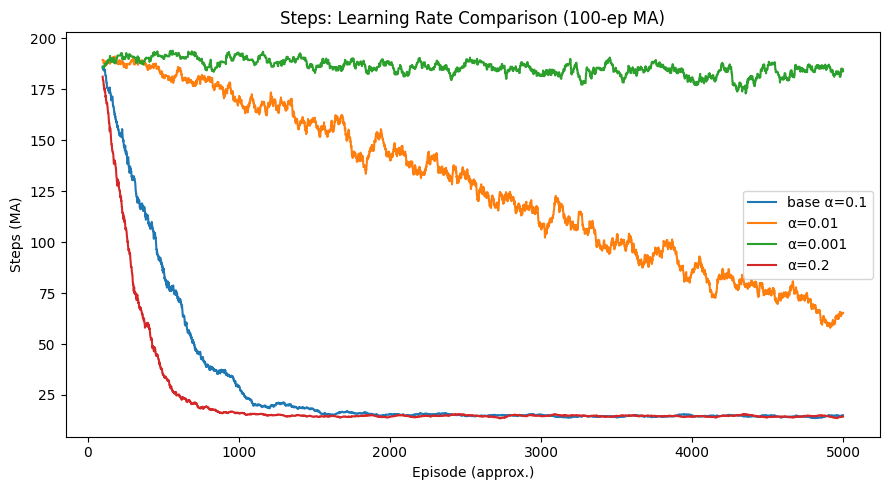

[Episode   500] last500_avg_return=-223.32 last500_avg_steps=138.26
[Episode  1000] last500_avg_return=-51.96 last500_avg_steps= 46.40
[Episode  1500] last500_avg_return=-14.43 last500_avg_steps= 22.67
[Episode  2000] last500_avg_return= -7.58 last500_avg_steps= 18.50
[Episode  2500] last500_avg_return= -6.25 last500_avg_steps= 17.64
[Episode  3000] last500_avg_return= -4.62 last500_avg_steps= 16.91
[Episode  3500] last500_avg_return= -4.18 last500_avg_steps= 16.53
[Episode  4000] last500_avg_return= -4.86 last500_avg_steps= 17.02
[Episode  4500] last500_avg_return= -4.31 last500_avg_steps= 16.60
[Episode  5000] last500_avg_return= -4.71 last500_avg_steps= 16.79

=== Exploration Sweep: ϵ=0.2 (α=0.1, γ=0.9) ===
Total Episodes: 5000
Average Steps per Episode: 32.73
Average Return per Episode: -32.62
[Episode   500] last500_avg_return=-256.78 last500_avg_steps=138.17
[Episode  1000] last500_avg_return=-78.09 last500_avg_steps= 53.72
[Episode  1500] last500_avg_return=-29.21 last500_avg_st

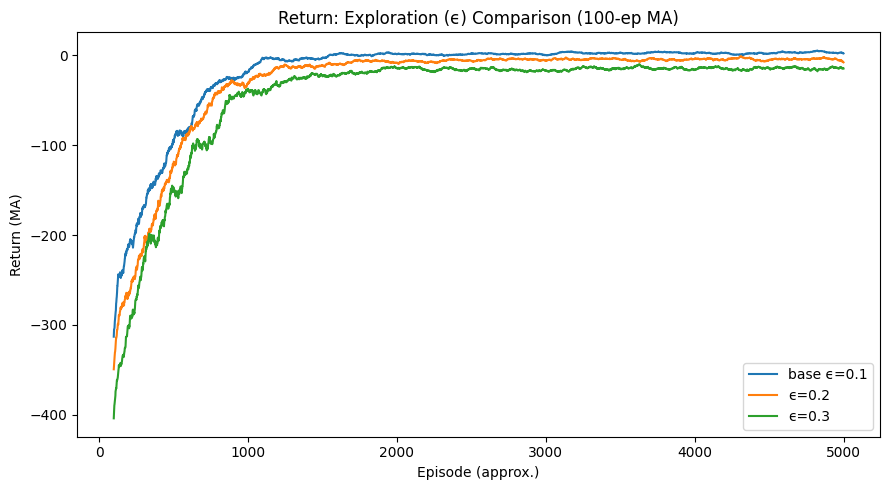

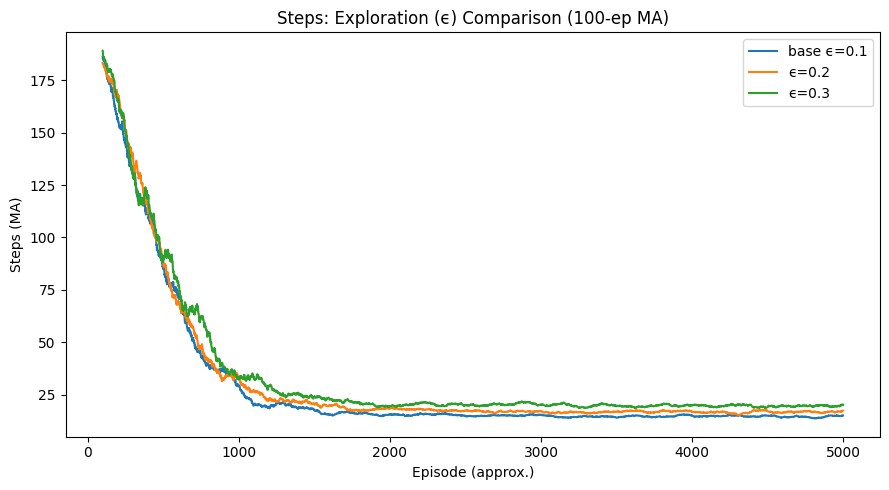

In [14]:
# ==== CSCN8020 – Q-Learning on Taxi-v3: complete assignment cell ====
# Trains base run, reports metrics, runs α & ε sweeps, plots inline, and plays visual policy.
# No edits to assignment2_utils.py needed.

import time
import numpy as np
import matplotlib.pyplot as plt
import gym
from IPython.display import clear_output, display

# -------------------------------------------------
# (Optional) Use helper if present — we DO NOT modify it.
# -------------------------------------------------
USE_HELPER = False
try:
    from assignment2_utils import describe_env, describe_obs
    USE_HELPER = True
except Exception:
    pass

# -------------------------------------------------
# Gym compatibility helpers (works across gym APIs)
# -------------------------------------------------
def reset_state(env):
    """Return just the state regardless of (state, info) vs state-only reset()."""
    out = env.reset()
    return out[0] if isinstance(out, tuple) else out

def step_env(env, action):
    """
    Step wrapper that returns (next_state, reward, done) across gym APIs.
    - gym 0.26+: (obs, reward, terminated, truncated, info)
    - older gym : (obs, reward, done, info)
    """
    res = env.step(action)
    if len(res) == 5:  # new API
        s_next, r, terminated, truncated, _ = res
        return s_next, r, bool(terminated or truncated)
    else:
        s_next, r, done, _ = res
        return s_next, r, bool(done)

# -------------------------------------------------
# Visual playback (tries human → rgb_array → ansi)
# -------------------------------------------------
def play_policy_visual(agent, episodes=2, step_delay=0.08):
    """
    1) human window (pygame) -> looks like the sprite screenshot
    2) rgb_array inline (animated in the notebook)
    3) ansi inline (text grid)
    """
    # 1) HUMAN window (pygame)
    try:
        env = gym.make("Taxi-v3", render_mode="human")
        for _ in range(episodes):
            s = reset_state(env)
            done = False
            while not done:
                a = agent.select_action(s)
                s, r, done = step_env(env, a)
                time.sleep(step_delay)
        env.close()
        return
    except Exception as e:
        print("human render unavailable → trying inline animation (rgb_array). Reason:", e)

    # 2) RGB-ARRAY inline animation
    try:
        env = gym.make("Taxi-v3", render_mode="rgb_array")
        frame = env.render()
        fig, ax = plt.subplots(figsize=(6, 4))
        im = ax.imshow(frame)
        ax.axis("off")
        display(fig)

        for _ in range(episodes):
            s = reset_state(env)
            done = False
            while not done:
                a = agent.select_action(s)
                s, r, done = step_env(env, a)
                frame = env.render()
                im.set_data(frame)
                fig.canvas.draw_idle()
                clear_output(wait=True)
                display(fig)
                time.sleep(step_delay)
        plt.close(fig)
        env.close()
        return
    except Exception as e:
        print("rgb_array unavailable → falling back to ANSI text. Reason:", e)

    # 3) ANSI text fallback
    env = gym.make("Taxi-v3", render_mode="ansi")
    for _ in range(episodes):
        s = reset_state(env)
        done = False
        while not done:
            clear_output(wait=True)
            print(env.render())
            a = agent.select_action(s)
            s, r, done = step_env(env, a)
            time.sleep(step_delay)
    env.close()

# -------------------------------------------------
# Utilities: smoothing, summaries, plotting inline
# -------------------------------------------------
def moving_avg(x, k=100):
    x = np.asarray(x, dtype=float)
    if x.size == 0:
        return np.array([])
    k = max(1, min(k, x.size))
    c = np.cumsum(np.insert(x, 0, 0.0))
    return (c[k:] - c[:-k]) / float(k)

def print_summary(returns, steps, title):
    print(f"\n=== {title} ===")
    print(f"Total Episodes: {len(returns)}")
    print(f"Average Steps per Episode: {np.mean(steps):.2f}")
    print(f"Average Return per Episode: {np.mean(returns):.2f}")

def plot_base_curves_inline(returns, steps, tag="base"):
    # 1) Return per episode
    plt.figure(figsize=(8, 4))
    plt.plot(returns)
    plt.title(f"Return per Episode ({tag})")
    plt.xlabel("Episode"); plt.ylabel("Return")
    plt.tight_layout(); plt.show()

    # 2) Steps per episode
    plt.figure(figsize=(8, 4))
    plt.plot(steps)
    plt.title(f"Steps per Episode ({tag})")
    plt.xlabel("Episode"); plt.ylabel("Steps")
    plt.tight_layout(); plt.show()

    # 3) Return (100-ep MA)
    r_ma = moving_avg(returns, 100)
    if r_ma.size:
        plt.figure(figsize=(8, 4))
        plt.plot(np.arange(100-1, r_ma.size + 100 - 1), r_ma)
        plt.title(f"Return (100-ep Moving Average) ({tag})")
        plt.xlabel("Episode (offset by MA window)"); plt.ylabel("Return (MA)")
        plt.tight_layout(); plt.show()

    # 4) Steps (100-ep MA)
    s_ma = moving_avg(steps, 100)
    if s_ma.size:
        plt.figure(figsize=(8, 4))
        plt.plot(np.arange(100-1, s_ma.size + 100 - 1), s_ma)
        plt.title(f"Steps (100-ep Moving Average) ({tag})")
        plt.xlabel("Episode (offset by MA window)"); plt.ylabel("Steps (MA)")
        plt.tight_layout(); plt.show()

    # 5) Summary panel (inline text)
    fig = plt.figure(figsize=(8, 1.8))
    txt = (
        f"Summary ({tag})\n"
        f"Total Episodes: {len(returns)}   |   "
        f"Average Steps/Episode: {np.mean(steps):.2f}   |   "
        f"Average Return/Episode: {np.mean(returns):.2f}"
    )
    fig.text(0.5, 0.5, txt, ha="center", va="center")
    plt.axis("off"); plt.tight_layout(); plt.show()

def compare_runs_ma_inline(curves_dict, title, ylabel, k=100):
    plt.figure(figsize=(9, 5))
    for label, arr in curves_dict.items():
        arr = np.asarray(arr, dtype=float)
        ma = moving_avg(arr, k=k)
        if ma.size:
            x = np.arange(k-1, ma.size + k - 1)
            plt.plot(x, ma, label=label)
    plt.title(f"{title} ({k}-ep MA)")
    plt.xlabel("Episode (approx.)"); plt.ylabel(ylabel)
    plt.legend(); plt.tight_layout(); plt.show()

# -------------------------------------------------
# Q-Learning Agent (tabular)
# -------------------------------------------------
class QLearningAgent:
    def __init__(self, n_states, n_actions, alpha=0.1, gamma=0.9, epsilon=0.1, seed=123):
        self.n_states  = int(n_states)
        self.n_actions = int(n_actions)
        self.alpha     = float(alpha)
        self.gamma     = float(gamma)
        self.epsilon   = float(epsilon)
        self.rng       = np.random.default_rng(seed)
        self.Q = np.zeros((self.n_states, self.n_actions), dtype=np.float32)

    def select_action(self, s):
        if self.rng.random() < self.epsilon:
            return int(self.rng.integers(0, self.n_actions))
        return int(np.argmax(self.Q[s]))

    def update(self, s, a, r, s_next, done):
        best_next = 0.0 if done else float(np.max(self.Q[s_next]))
        td_target = r + self.gamma * best_next
        td_error  = td_target - self.Q[s, a]
        self.Q[s, a] += self.alpha * td_error

    def train(self, env, episodes=5000, max_steps=200, verbose_every=500):
        returns, steps = [], []
        for ep in range(1, episodes + 1):
            s = reset_state(env)
            done = False
            ep_ret = 0.0
            ep_steps = 0
            while (not done) and (ep_steps < max_steps):
                a = self.select_action(s)
                s_next, r, done = step_env(env, a)
                self.update(s, a, r, s_next, done)
                s = s_next
                ep_ret   += r
                ep_steps += 1
            returns.append(ep_ret)
            steps.append(ep_steps)
            if verbose_every and (ep % verbose_every == 0):
                print(f"[Episode {ep:5d}] last{verbose_every}_avg_return={np.mean(returns[-verbose_every:]):6.2f} "
                      f"last{verbose_every}_avg_steps={np.mean(steps[-verbose_every:]):6.2f}")
        return np.array(returns, dtype=np.float32), np.array(steps, dtype=np.int32)

# -------------------------------------------------
# 1) Base run (α=0.1, ϵ=0.1, γ=0.9) + metrics + plots + visual playback
# -------------------------------------------------
base_env = gym.make("Taxi-v3")  # training env (no rendering needed)
n_states, n_actions = base_env.observation_space.n, base_env.action_space.n
if USE_HELPER:
    describe_env(base_env)  # prints environment specs

base_agent = QLearningAgent(n_states, n_actions, alpha=0.1, gamma=0.9, epsilon=0.1, seed=123)
base_returns, base_steps = base_agent.train(base_env, episodes=5000, max_steps=200, verbose_every=500)

# Required metrics for base
print_summary(base_returns, base_steps, "Base Run (α=0.1, ϵ=0.1, γ=0.9)")
# Base plots (4 curves + 1 summary panel)
plot_base_curves_inline(base_returns, base_steps, tag="base")

# Visual playback (sprite window if possible; else inline animation/text)
print("\nPlaying trained policy visually (window/inline fallback):")
play_policy_visual(base_agent, episodes=2, step_delay=0.08)

# Optional: decode one state with helper (no edits)
if USE_HELPER:
    s_example = reset_state(base_env)
    print("\nState breakdown example (helper):")
    describe_obs(s_example)

base_env.close()

# -------------------------------------------------
# 2) Learning Rate sweep (ϵ=0.1, γ=0.9) — α ∈ {0.01, 0.001, 0.2}
# -------------------------------------------------
alphas = [0.01, 0.001, 0.2]
lr_returns, lr_steps = {}, {}
for a in alphas:
    env = gym.make("Taxi-v3")
    agent = QLearningAgent(n_states, n_actions, alpha=a, gamma=0.9, epsilon=0.1, seed=100 + int(a*1000))
    r, s = agent.train(env, episodes=5000, max_steps=200, verbose_every=500)
    print_summary(r, s, f"LR Sweep: α={a} (ϵ=0.1, γ=0.9)")
    lr_returns[f"α={a}"] = r
    lr_steps[f"α={a}"]  = s
    env.close()

# α comparisons (2 plots)
compare_runs_ma_inline({"base α=0.1": base_returns, **lr_returns},
                       "Return: Learning Rate Comparison", "Return (MA)", k=100)
compare_runs_ma_inline({"base α=0.1": base_steps, **lr_steps},
                       "Steps: Learning Rate Comparison", "Steps (MA)", k=100)

# -------------------------------------------------
# 3) Exploration sweep (α=0.1, γ=0.9) — ϵ ∈ {0.2, 0.3}
# -------------------------------------------------
epsilons = [0.2, 0.3]
eps_returns, eps_steps = {}, {}
for e in epsilons:
    env = gym.make("Taxi-v3")
    agent = QLearningAgent(n_states, n_actions, alpha=0.1, gamma=0.9, epsilon=e, seed=200 + int(e*10))
    r, s = agent.train(env, episodes=5000, max_steps=200, verbose_every=500)
    print_summary(r, s, f"Exploration Sweep: ϵ={e} (α=0.1, γ=0.9)")
    eps_returns[f"ϵ={e}"] = r
    eps_steps[f"ϵ={e}"]  = s
    env.close()

# ε comparisons (2 plots)
compare_runs_ma_inline({"base ϵ=0.1": base_returns, **eps_returns},
                       "Return: Exploration (ϵ) Comparison", "Return (MA)", k=100)
compare_runs_ma_inline({"base ϵ=0.1": base_steps, **eps_steps},
                       "Steps: Exploration (ϵ) Comparison", "Steps (MA)", k=100)


